In [ ]:
!nvidia-smi 

Sun Dec 13 05:45:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    30W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from pathlib import Path
import numpy as np
import csv
import re
import cv2
from google.colab.patches import cv2_imshow

def read_calib(calib_file_path):
    with open(calib_file_path, 'r') as calib_file:
        calib = {}
        csv_reader = csv.reader(calib_file, delimiter='=')
        for attr, value in csv_reader:
            calib.setdefault(attr, value)

    return calib

In [ ]:
def read_pfm(pfm_file_path):
    with open(pfm_file_path, 'rb') as pfm_file:
        header = pfm_file.readline().decode().rstrip()
        channels = 3 if header == 'PF' else 1
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', pfm_file.readline().decode('utf-8'))
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception("no pfm")
        scale = float(pfm_file.readline().decode().rstrip())
        if scale < 0:
            e = '<' 
            scale = -scale
        else:
            e = '>' 
        dispariy = np.fromfile(pfm_file, e + 'f')

    img = np.reshape(dispariy, newshape=(height, width, channels))
    img = np.flipud(img).astype('uint8')
    # show(img, "disparity")

    return dispariy, [(height, width, channels), scale]

In [ ]:
def create_depth_map(pfm_file_path, calib=None):
    dispariy, [shape,scale] = read_pfm(pfm_file_path)
    if calib is None:
        raise Exception("no calib")
    else:
        fx = float(calib['cam0'].split(' ')[0].lstrip('['))
        base_line = float(calib['baseline'])
        doffs = float(calib['doffs'])
        depth_map = fx*base_line/(dispariy/scale + doffs)
        depth_map = np.reshape(depth_map, newshape=shape)
        depth_map = np.flipud(depth_map).astype('uint8')

        return depth_map

In [ ]:
def show(img, win_name='image'):
    if img is None:
        raise Exception("no image")
    else:
        cv2_imshow(img)
        cv2.waitKey()

In [ ]:
from google.colab import drive
drive.mount('data/')

Drive already mounted at data/; to attempt to forcibly remount, call drive.mount("data/", force_remount=True).


In [ ]:
pfm_file_dir = Path(r'/content/data/MyDrive/Stereo Vision/Bicycle1-perfect')
calib_file_path = pfm_file_dir.joinpath('calib.txt')
disp_left = pfm_file_dir.joinpath('disp0.pfm')

calib = read_calib(calib_file_path)
depth_map_left = create_depth_map(disp_left, calib)
# show(depth_map_left, "depth_map")

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary

In [ ]:
class StereoData(Dataset):

    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.X = []
        self.y = []
        for folder_path in os.listdir(path):
            folder_path = path+folder_path
            left = np.array(Image.open(f'{folder_path}/im1.png'))
            right = np.array(Image.open(f'{folder_path}/im0.png'))
            disp = f'{folder_path}/disp0.pfm'
            try:
                calib = f'{folder_path}/calib.txt'
                calib_ = read_calib(calib)
                disp_map = create_depth_map(disp, calib_)
            except:
                disp_map = create_depth_map(disp)
            self.X.append([left, right])
            self.y.append(disp_map)
            
    def __getitem__(self, idx):
        left = self.transform(Image.fromarray(self.X[idx][0]))
        right = self.transform(Image.fromarray(self.X[idx][1]))
        img = torch.cat([left, right], dim = 0)
        x, y, c = self.y[idx].shape
        label = self.transform(Image.fromarray(self.y[idx].reshape(x, y)))
        return (img, label)

    def __len__(self):
        return len(self.X)

In [ ]:
transform = transforms.Compose([
            transforms.Resize((300, 300)),
            transforms.ToTensor()
])

dataset = StereoData(r'/content/data/MyDrive/Stereo Vision/', transform)

In [ ]:
train_dl = DataLoader(dataset, batch_size= 1, shuffle= True)

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=6, out_channels=1):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)
        self.conv5 = self.contract_block(256, 256, 3, 1)

        self.upconv5 = self.expand_block(256, 256, 3, 1)
        self.upconv4 = self.expand_block(512, 128, 3, 1)
        self.upconv3 = self.expand_block(256, 64, 3, 1)
        self.upconv2 = self.expand_block(128, 32, 3, 1)
        self.upconv1 = self.expand_block(64, out_channels, 3, 1)

    def __call__(self, x):

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        upconv5 = self.upconv5(conv5)
        
        upconv4 = self.upconv4(torch.cat([upconv5, conv4], 1))
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
            )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
            )
        return expand

In [ ]:
device = 'cuda'
model = UNET()
model = model.to(device)

summary(model, (6, 300, 300))
# model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 300, 300]           9,440
       BatchNorm2d-2         [-1, 32, 300, 300]              64
              ReLU-3         [-1, 32, 300, 300]               0
            Conv2d-4         [-1, 32, 300, 300]          50,208
       BatchNorm2d-5         [-1, 32, 300, 300]              64
              ReLU-6         [-1, 32, 300, 300]               0
            Conv2d-7         [-1, 64, 300, 300]          18,496
       BatchNorm2d-8         [-1, 64, 300, 300]             128
              ReLU-9         [-1, 64, 300, 300]               0
           Conv2d-10         [-1, 64, 300, 300]          36,928
      BatchNorm2d-11         [-1, 64, 300, 300]             128
             ReLU-12         [-1, 64, 300, 300]               0
           Conv2d-13        [-1, 128, 300, 300]          73,856
      BatchNorm2d-14        [-1, 128, 3

In [ ]:
loss_fun = nn.MSELoss()

def fit(model, train_dl, epochs, lr= 1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    for epoch in range(epochs):
        train_loss = []
        for batch in train_dl:
            img, label = batch
            img = img.to('cuda')
            label = label.to('cuda')
            out = model(img)
            loss = loss_fun(out, label)
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epoch: {epoch+1}/{epochs} -- Loss: {sum(train_loss)/len(train_loss)}')
        fig=plt.figure(figsize=(2, 1))
        fig.add_subplot(1, 2, 1)
        plt.imshow(np.array(label[0].cpu().detach()).reshape(300, 300), cmap= 'gray')
        fig.add_subplot(1, 2, 2)
        plt.imshow(np.array(out[0].cpu().detach()).reshape(300, 300), cmap= 'gray')
        plt.show()
        

Epoch: 1/100 -- Loss: 0.010640461929142475


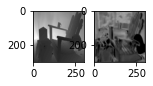

Epoch: 2/100 -- Loss: 0.009655840694904327


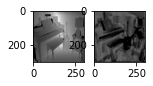

Epoch: 3/100 -- Loss: 0.009853394702076912


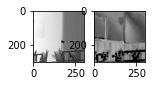

Epoch: 4/100 -- Loss: 0.009630300104618073


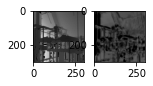

Epoch: 5/100 -- Loss: 0.008999737910926342


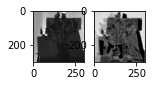

Epoch: 6/100 -- Loss: 0.00882928166538477


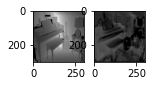

Epoch: 7/100 -- Loss: 0.009582480415701866


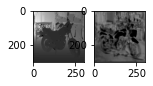

Epoch: 8/100 -- Loss: 0.009211643598973751


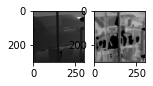

Epoch: 9/100 -- Loss: 0.009128080680966377


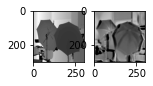

In [ ]:
fit(model, train_dl, 100)

In [ ]:
torch.save(model, '/content/data/MyDrive/Depth_model_200')